# Using the Snorkel-labeled Dataset for Image Classification
Indoor / Outdoor Image Classification

In this notebook, you will leverage transfer learning for image classification, using the indoor/outdoor dataset that has been labeled by Snorkel. 
Specifically, you will learn how to build a deep learning model for image classification of an image dataset, consisting of indoor and outdoor scenes. 

The techniques described in this chapter can be used for image classification for any image datasets


### Credits: 

Based on code adpated from the Pytorch tutorial for transfer learning
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


In [1]:
import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import os
import time
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
%matplotlib inline

In [2]:
# Specify image folder
image_dir = '../data/'

In [5]:
# Compute the mean and standard deviation of the image dataset
train_dataset = datasets.ImageFolder(
                os.path.join(image_dir, "train"),
                transform=transforms.Compose([transforms.Resize(224),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor()])
            )




Next, we specify the mean and standard deviation for each of the three channels for the images.

These are defaults used for the ImageNet dataset and are generally applicable for most image datasets.

In [6]:
# Or we can use the default from ImageNet
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

### Computing Mean/Standard Deviation for your dataset
You can compute the mean, standard deviation for all the images in the indoor/outdoor dataset as well.  The following code snippet shown first loads the entire training set as one batch by using the next() function to return it. Once loaded, the mean and standard deviation for the training set is computed.

Uncomment the code in the next cell if you want to compute it.

In [7]:
#loader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=1)
#data = next(iter(loader))
#mean, std = data[0].mean(), data[0].std()

### Specify the transformations that will be used for the training, validation, and testing datasets

You will notice in the code shown below that for the training dataset, we first apply _RandomResizedCrop_ and _RandomHorizontalFlip_.
_RandomResizedCrop_ crops each of the training images to a random size and then outputs an image that is 224 x 224. 

_RandomHorizontalFlip_ randomly performs horizontal flipping of the 224 x 224 images. The image is then converted to tensor, and the tensor values normalized to the mean and standard deviation provided.

For the validation and testing images, we resize each image to 224 x 224, and performs a _CenterCrop_. The image is then converted to tensor, and the tensor values normalized to the mean and standard deviation provided.


In [8]:
# Specify the image transformation for both the training and val dataset
image_transformations = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
        'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

### Load the training, validation and test datasets from the data folder

In [10]:
# load the training,  validation, and test data
image_datasets = {}
dataset_sizes  = {}
dataloaders    = {}
batch_size     = 8

for data_folder in ['train', 'val', 'test']:
     dataset = datasets.ImageFolder(
                os.path.join(image_dir, data_folder),
                transform=image_transformations[data_folder])
     
     loader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size,
                                        shuffle=True, 
                                        num_workers=2)

     # store the dataset/loader/sizes for reference later
     image_datasets[data_folder] = dataset
     dataloaders[data_folder] = loader
     dataset_sizes[data_folder] = len(dataset)

In [11]:
# Get the classes 
class_names = image_datasets["train"].classes
class_names

['indoor', 'outdoor']

In [12]:
# get the size of train, validation and test data
dataset_sizes

{'train': 1609, 'val': 247, 'test': 188}

## Utility Functions
Credits: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Next, let us define two utility functions (_visualize_images_, and _model_predictions_ ) that will be used later for displaying the training and testing images, and computing the predictions for the test dataset.

_visualize_images()_ is a function for visualizing images in an image grid. By default, it shows 16 images from the _images_ array. 
The array _labels_ is passed to the function to show the class names for each of the images displayed. 
If an optional array _predictions_ is provided, both the ground truth label and the predicted label will be shown side by side.

You will notice that we multiplied the value of _inp_ by 255, and then cast it as a _uint8_ data type. 
This helps to convert the values from 0 to 1 to 0 to 255. 
It also helps to reduce the clipping errors that might occur due to negative values in the _inp_ variable.

In [13]:
def imshow(axis, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    axis.imshow((inp * 255).astype(np.uint8))

In [15]:
def visualize_images(images, labels, predictions=None,  num_images=16):
    
    count = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05 )

    # get the predictions for data in dataloader
    for i in range(0,len(images)):
        ax = grid[count]
        
        inp = images[i].numpy().transpose((1, 2, 0))
        inp = std * inp + mean
        ax.imshow((inp * 255).astype(np.uint8))

        if (predictions is None):
          info = '{}'.format(class_names[labels[i]])
        else :
          info = '{}/{}'.format(class_names[labels[i]], 
          class_names[predictions[i]])

        ax.text(10, 20, '{}'.format(info), color='w', 
                backgroundcolor='black', 
                alpha=0.8,
                size=15)

        count += 1
        if count == num_images:
          return


In [16]:
# given a dataloader, get the predictions using the model provided.
def model_predictions(dataloder, model):     
    predictions = []
    images = []
    label_list = []

    # get the predictions for data in dataloader
    for i, (inputs, labels) in enumerate(dataloder):
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        predictions.append(preds.cpu())
        label_list.append(labels.cpu())

        for j in range(inputs.size()[0]):
            images.append(inputs.cpu().data[j])

    predictions_f = list(np.concatenate(predictions).flat)
    label_f = list(np.concatenate(label_list).flat)

    return predictions_f,  label_f, images     

## Visualize the training data

In [19]:
# get the data
# Get a batch of training data
images, labels = next(iter(dataloaders['train']))



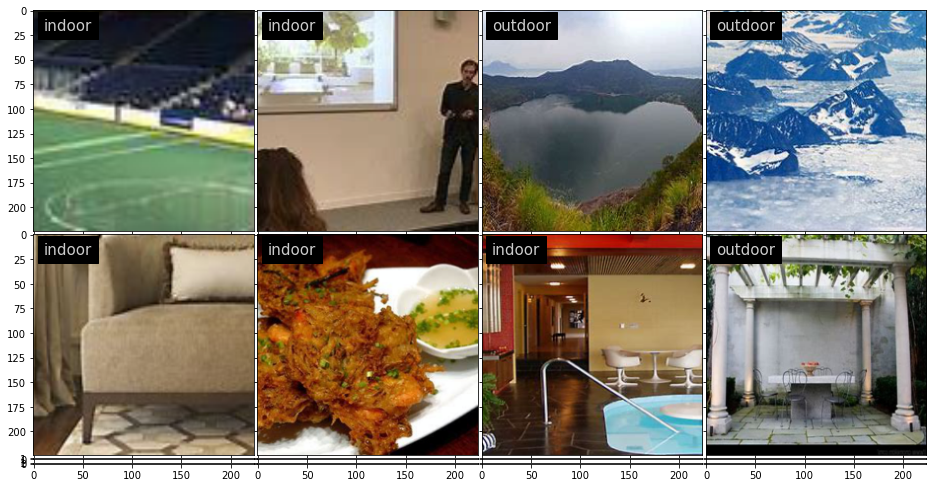

In [20]:
# visualize the images and labels, and display in a grid
visualize_images(images, labels)


## Fine-tuning the pre-trained model

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
# Load Resnet50 model
model = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/wandavision/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
# Specify a final layer with 2 classes - indoor and outdoor
num_classes = 2
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_classes)

In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Use CrossEntropyLoss as a loss function
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.8)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8)


In [25]:
# Push model to default device / GPU if available
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
def train(model, criterion, optimizer, scheduler, num_epochs=10):
    # use to store the training and validation loss
    training_loss = []
    val_loss = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Note the start time of the training
    start_time = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}, '.format(epoch+1, num_epochs), end = ' ' )

        # iterate through training and validation phase
        for phase in ['train', 'val']:

            total_loss = 0.0
            total_corrects = 0

            if phase == 'train':
                model.train()  
                print("[Training] ", end=' ')
            elif phase == 'val':
                model.eval()  
                print("[Validation] ", end=' ')
            else:
                print("Not supported phase")

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Reset the optimizer gradients
                optimizer.zero_grad()

                if phase == 'train':
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    loss.backward()
                    optimizer.step()
                else:
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)                

                total_loss += loss.item() * inputs.size(0)
                total_corrects += torch.sum(preds == labels.data)

            # compute loss and accuracy
            epoch_loss = total_loss / dataset_sizes[phase]
            epoch_accuracy =  (total_corrects + 0.0) / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                training_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
            
                
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights  = copy.deepcopy(model.state_dict())

            print('Loss: {:.3f} Accuracy: {:.3f}, '.format(
             epoch_loss, epoch_accuracy), end=' ')


        print()

    # Elapse time
    time_elapsed = time.time() - start_time

    print ('Train/Validation Duration: %s' 
          % time.strftime("%H:%M:%S", time.gmtime(time_elapsed)))
    print('Best Validation Accuracy: {:3f}'.format(best_accuracy))

    # Load the best weights to the model
    model.load_state_dict(best_model_weights )
    return model, training_loss, val_loss 

In [34]:
best_model, train_loss, val_loss = train(
                    model, 
                    loss_function, 
                    optimizer, 
                    scheduler,
                    num_epochs=25)

Epoch 1/25,  [Training]  Loss: 0.446 Accuracy: 0.785,  [Validation]  Loss: 0.205 Accuracy: 0.935,  
Epoch 2/25,  [Training]  Loss: 0.340 Accuracy: 0.851,  [Validation]  Loss: 0.203 Accuracy: 0.931,  
Epoch 3/25,  [Training]  Loss: 0.346 Accuracy: 0.852,  [Validation]  Loss: 0.208 Accuracy: 0.935,  
Epoch 4/25,  [Training]  Loss: 0.334 Accuracy: 0.850,  [Validation]  Loss: 0.248 Accuracy: 0.919,  
Epoch 5/25,  [Training]  Loss: 0.336 Accuracy: 0.854,  [Validation]  Loss: 0.217 Accuracy: 0.931,  
Epoch 6/25,  [Training]  Loss: 0.313 Accuracy: 0.865,  [Validation]  Loss: 0.299 Accuracy: 0.895,  
Epoch 7/25,  [Training]  Loss: 0.304 Accuracy: 0.874,  [Validation]  Loss: 0.230 Accuracy: 0.919,  
Epoch 8/25,  [Training]  Loss: 0.339 Accuracy: 0.853,  [Validation]  Loss: 0.235 Accuracy: 0.923,  
Epoch 9/25,  [Training]  Loss: 0.305 Accuracy: 0.866,  [Validation]  Loss: 0.236 Accuracy: 0.919,  
Epoch 10/25,  [Training]  Loss: 0.300 Accuracy: 0.876,  [Validation]  Loss: 0.209 Accuracy: 0.939,  

## Model Evaluation

Now that we have identified the best model, let us use it to predict the class for the images in the test dataset.

To do this, we use the utility function that we have defined earlier, _model_predictions()_. 

We provide as inputs the dataloader for the test dataset, and the best model (i.e. _best_model_).


In [35]:
# Use the model for prediction using the test dataset
predictions, labels, images = model_predictions(dataloaders["test"],best_model)

In [36]:
# print out the classification report
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        61
           1       0.92      0.83      0.87       127

    accuracy                           0.84       188
   macro avg       0.81      0.84      0.82       188
weighted avg       0.85      0.84      0.84       188



In [37]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC: %.4f' % (roc_auc_score(labels, predictions)))


ROC_AUC: 0.8396


## Visualize results
Let us visualize the ground-truth and predicted labels for each of the test images. 
To do this, we use the utility function _visualize_images()_, and pass as inputs: test images, labels, and predicted labels.

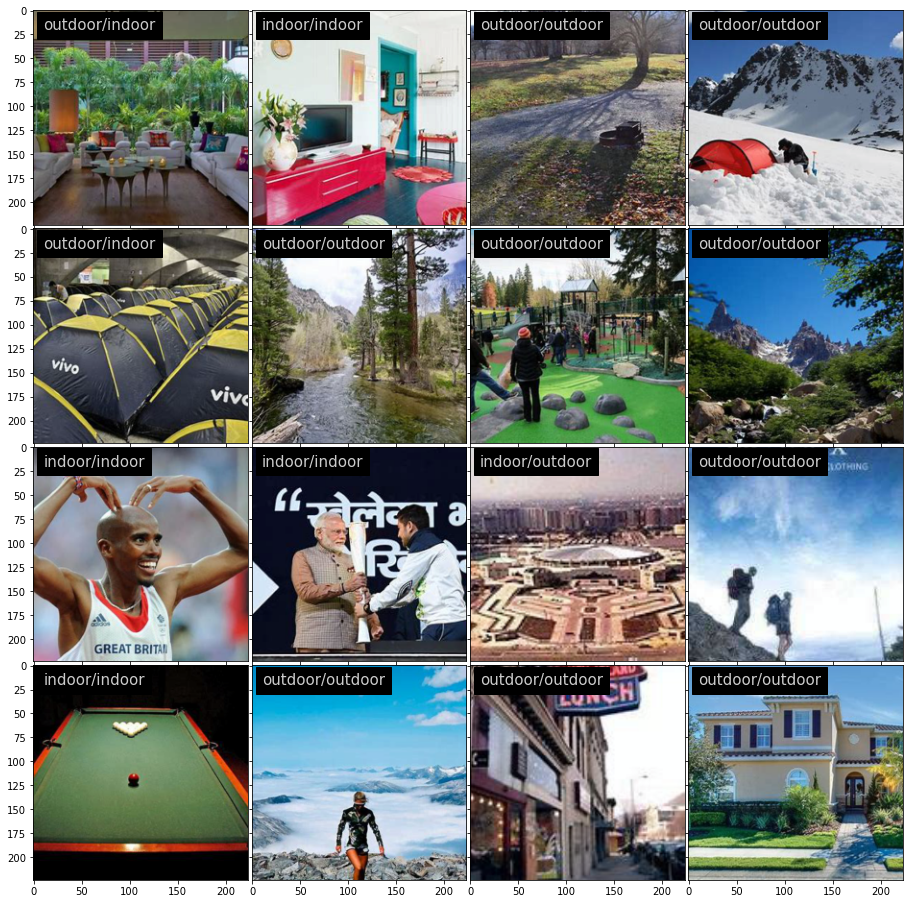

In [39]:
# Show the label, and prediction
visualize_images(images, labels, predictions )